In [103]:
# Imports

import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import torch
from scipy import signal
import imageio
from scipy.ndimage import gaussian_filter
from scipy import ndimage
import cv2
from tqdm import tqdm
import json
import pandas as pd
import statistics

from utility import calc_fowlkes_mallows, conv_mat_representation

# of Stimuli:  18
Stimuli Shape:  (20, 3)
[[708 106   0]
 [683 117   0]
 [702 105   0]
 [732  86   0]
 [694 139   0]
 [348 314   1]
 [325 318   1]
 [355 244   1]
 [370 310   1]
 [387 306   1]
 [197 488   2]
 [262 486   2]
 [163 486   2]
 [224 475   2]
 [226 500   2]
 [265 161   3]
 [250 127   3]
 [191 137   3]
 [198 168   3]
 [195 142   3]]
# of Visual Stimuli:  18
Visual Stimuli Shape:  (500, 800)


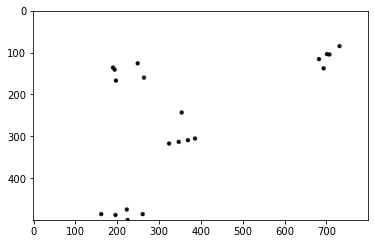

In [104]:
# Load Data 

rgb_weights = [0.2989, 0.5870, 0.1140]

def load_gaussian_clusters(file_path):
    raw_data_path = list(Path(file_path).iterdir())
    raw_data_path.sort()

    data = []

    for path in raw_data_path:
        data.append(np.load(path, allow_pickle=True))
    
    return data

def load_gaussian_visual_stimuli(file_path):
    raw_data_path = list(Path(file_path).iterdir())
    raw_data_path.sort()

    images = []

    for path in raw_data_path:
        im = imageio.imread(path)
        im = np.dot(im[...,:3], rgb_weights)
        images.append(im)
    
    return images


idx = 9
# idx = 1

data = load_gaussian_clusters("../stimuli/normalized_gaussian_clusters")
print("# of Stimuli: ", len(data))
points = data[idx]
print("Stimuli Shape: ", points.shape)

print(points)


visual_stimuli = load_gaussian_visual_stimuli("../stimuli/normalized_gaussian_visual_stimuli")
print("# of Visual Stimuli: ", len(visual_stimuli))
im = visual_stimuli[idx]
print("Visual Stimuli Shape: ", im.shape)

plt.imshow(im, cmap=plt.get_cmap("gray"))
plt.savefig("conv_results/gaussian_original.png")

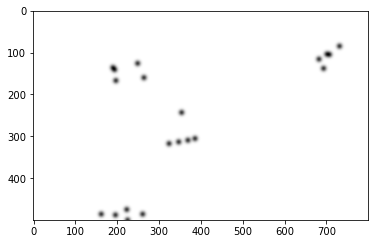

In [105]:
# Gaussian Filter

def apply_gaussian_filter(im):
    h, w = im.shape
    g_im = gaussian_filter(im, sigma=4)
    return g_im

g_im = apply_gaussian_filter(im)
plt.imshow(g_im, cmap=plt.get_cmap("gray"))
plt.savefig("conv_results/gaussian_blur.png")

Shape Before Averaging Convolution:  (500, 800)
Shape After Averaging Convolution:  (439, 701)


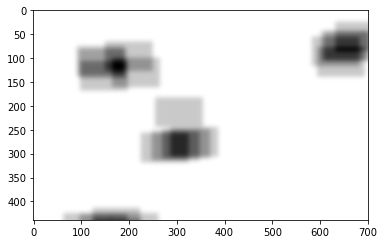

In [106]:
# Average Convolution

def avg_conv_2d(im, kernel = None, sf = 8):
    if kernel is None:
        h, w = im.shape
        k_h, k_w = int(h/sf), int(w/sf)
        kernel = np.ones((k_h, k_w)).astype(float) / (k_h*k_w)
        
    out = signal.convolve2d(im, kernel, mode='valid')
    return out

print("Shape Before Averaging Convolution: ", g_im.shape)
conv_out = avg_conv_2d(g_im)
print("Shape After Averaging Convolution: ", conv_out.shape)

fig, ax1 = plt.subplots()
ax1.imshow(conv_out, cmap=plt.get_cmap("gray"))
plt.savefig("conv_results/gaussian_conv.png")

(500, 800)
Number of connected componenets found:  4


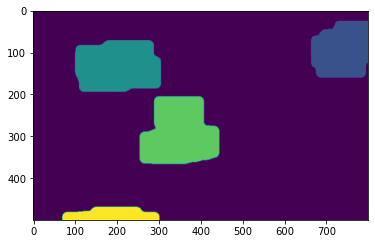

In [107]:
# Connected Componenets

def get_dilated_connected_componenets(conv_out, out_shape):
    bool_out = conv_out <= 254.00

    labels, nb = ndimage.label(bool_out)
    
    w, h = out_shape
    
    resized_labels = cv2.resize(labels.astype('float32'), (h, w))
    resized_labels = resized_labels.astype(int)

    return resized_labels, nb

    
cc_out, cc_n = get_dilated_connected_componenets(conv_out, im.shape)
print(cc_out.shape)
print("Number of connected componenets found: ", cc_n)
plt.imshow(cc_out)
plt.savefig("conv_results/gaussian_cc.png")

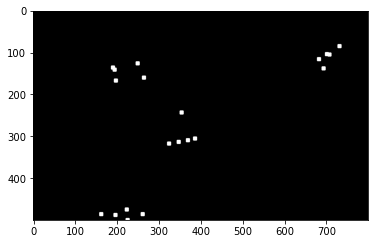

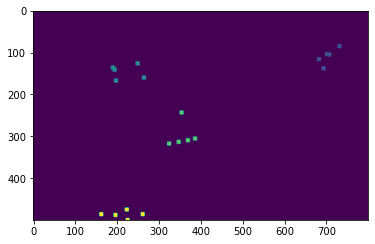

In [108]:
def cluster_visually(orig_im, cc_out):
    bool_im = orig_im <= 254.00
    
    visual_clusters = np.multiply(cc_out, bool_im)
    
    return bool_im, visual_clusters
    
    
bool_im, visual_clusters = cluster_visually(im, cc_out)
fig, ax = plt.subplots()
ax.imshow(bool_im, cmap=plt.get_cmap("gray"))

fig, ax = plt.subplots()
ax.imshow(visual_clusters)
plt.savefig("conv_results/gaussian_visual_clusters.png")


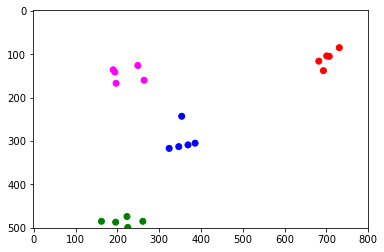

In [117]:
# Visualize True Clustering

colors = np.array(['red', 'blue', 'green', 'magenta', 'cyan'])
fig, ax1 = plt.subplots()
plt.xlim(-1, 800)
plt.ylim(-1, 500)
ax1.invert_yaxis()
ax1.scatter(x=points[:, 0] -1, y=points[:, 1] -1, c=colors[points[:, -1]])
plt.savefig("conv_results/gaussian_true_labels")

In [110]:
# Generate Predictions

def generate_predictions(visual_clusters, points):
    pred = np.copy(points)
    for i in range(pred.shape[0]):
        x, y, label = pred[i]
        pred_label = visual_clusters[y-1, x - 1]
        pred[i, -1] = pred_label
        
    return pred

pred = generate_predictions(visual_clusters, points)
    
print("Ground Truth: ", points)
print("Pred: ", pred)

Ground Truth:  [[708 106   0]
 [683 117   0]
 [702 105   0]
 [732  86   0]
 [694 139   0]
 [348 314   1]
 [325 318   1]
 [355 244   1]
 [370 310   1]
 [387 306   1]
 [197 488   2]
 [262 486   2]
 [163 486   2]
 [224 475   2]
 [226 500   2]
 [265 161   3]
 [250 127   3]
 [191 137   3]
 [198 168   3]
 [195 142   3]]
Pred:  [[708 106   1]
 [683 117   1]
 [702 105   1]
 [732  86   1]
 [694 139   1]
 [348 314   3]
 [325 318   3]
 [355 244   3]
 [370 310   3]
 [387 306   3]
 [197 488   4]
 [262 486   4]
 [163 486   4]
 [224 475   4]
 [226 500   4]
 [265 161   2]
 [250 127   2]
 [191 137   2]
 [198 168   2]
 [195 142   2]]


In [111]:
# Calculate FM Index

score = calc_fowlkes_mallows(points, pred)
print(score)

1.0


In [102]:
# Get Average FM Index for Gaussian Stimuli

fm_scores = []

for i, points in enumerate(tqdm(data)):
    im = visual_stimuli[i]
    g_im = apply_gaussian_filter(im)
    conv_out = avg_conv_2d(g_im, sf = 10)
    cc_out, cc_n = get_dilated_connected_componenets(conv_out, im.shape)
    bool_im, visual_clusters = cluster_visually(im, cc_out)
    pred = generate_predictions(visual_clusters, points)
    score = calc_fowlkes_mallows(points, pred)
    fm_scores.append(score)

print("\nAverage FM Score: ", statistics.mean(fm_scores))
print("\nMedian FM Score: ", statistics.median(fm_scores))
print("\nSTD FM Score: ", statistics.stdev(fm_scores))

100%|██████████| 18/18 [01:00<00:00,  3.35s/it]


Average FM Score:  0.9241952039397919

Median FM Score:  0.9486832980505138

STD FM Score:  0.11392822026756091


In [50]:
# Load Human Data

# stores 1 is stim is clustered, or 0 otherwise
stim_info = {}
unique_uuid_to_base_uuid = {} # creates mapping from unique_uuid to base_uuid

# Data format = {p_id_1: {stim_id_1: npy, stim_id_2: npy}, p_id_2: {stim_id_1: npy, stim_id_2: npy}, ... }
def load_clusters(file_path):
    raw_data_path = list(Path(file_path).iterdir())
    raw_data_path.sort()

    data = {}

    for path in raw_data_path:
        with open(str(path)) as f:
            p_id = str(path).split('/')[-1][0:-5]
            p_data = json.load(f)
            p_d = {}
            for p_stim in p_data:
                stim_id = p_stim["unique_uuid"]
                p_clusters = conv_mat_representation(p_stim["clusters"])
                p_d[stim_id] = p_clusters
                
                if stim_id not in stim_info.keys():
                    stim_info[stim_id] = 1 if p_stim["group"] == "clustered" else 0
                    
                if stim_id not in unique_uuid_to_base_uuid.keys():
                    unique_uuid_to_base_uuid[stim_id] = p_stim["base_uuid"]
            
            data[p_id] = p_d
        
    return data

def load_visual_stimuli(file_path):
    raw_data_path = list(Path(file_path).iterdir())
    raw_data_path.sort()

    images = {}

    for path in raw_data_path:
        im = imageio.imread(path)
        im = np.dot(im[...,:3], rgb_weights)
        
        stim_id = str(path).split('/')[-1][0:-4]
        images[stim_id] = im
    
    return images


human_visual_stimuli = load_visual_stimuli("../stimuli/Clustering_Images")
human_data = load_clusters("../stimuli/Clustering_Data")


Number of connected componenets found:  14
Score:  0.22454435656953592


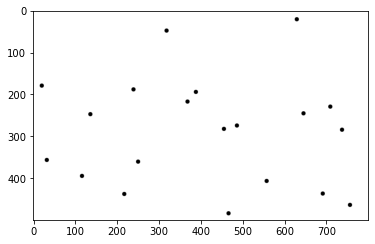

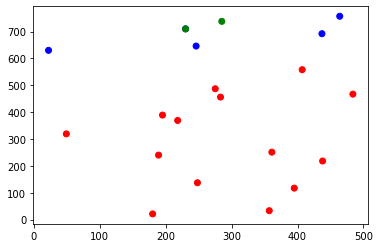

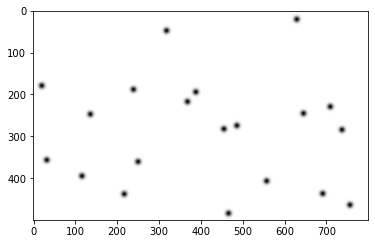

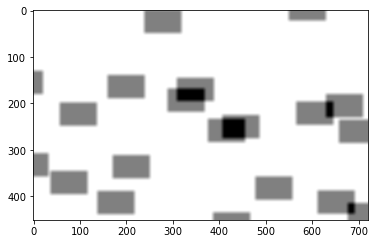

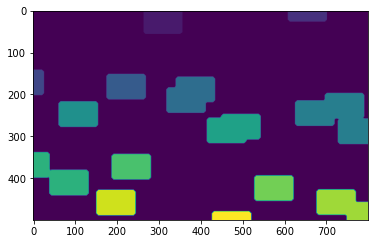

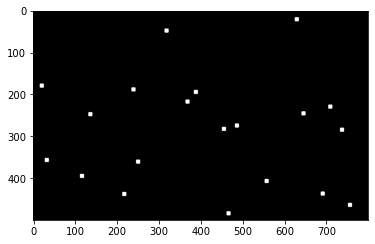

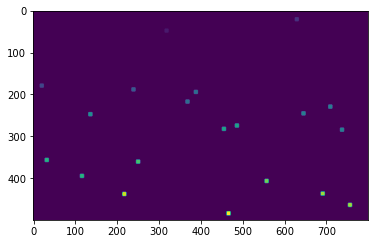

In [88]:
# Test on individual response
stim_id = 'e2b62069-e95a-4380-987e-b6b5935e7670'
im = human_visual_stimuli[stim_id]

fig, ax1 = plt.subplots()
ax1.imshow(im, cmap=plt.get_cmap("gray"))

points = human_data['1'][stim_id]
colors = np.array(['red', 'blue', 'green', 'cyan', 'magenta'])
fig, ax1 = plt.subplots()
ax1.scatter(x=points[:, 1], y=points[:, 0], c=colors[points[:, -1]])
plt.savefig("conv_results/human_labels")

g_im = apply_gaussian_filter(im)
fig, ax1 = plt.subplots()
ax1.imshow(g_im, cmap=plt.get_cmap("gray"))


conv_out = avg_conv_2d(im, sf = 10)
fig, ax1 = plt.subplots()
ax1.imshow(conv_out, cmap=plt.get_cmap("gray"))


cc_out, cc_n = get_dilated_connected_componenets(conv_out, im.shape)
fig, ax1 = plt.subplots()
ax1.imshow(cc_out)

bool_im, visual_clusters = cluster_visually(im, cc_out)
fig, ax1 = plt.subplots()
ax1.imshow(bool_im, cmap=plt.get_cmap("gray"))

fig, ax1 = plt.subplots()
ax1.imshow(visual_clusters)
plt.savefig("conv_results/model_labels")

pred = generate_predictions(visual_clusters, points)
score = calc_fowlkes_mallows(points, pred)

print("Score: ", score)

In [66]:
"""
Uncomment below to run model on all Human Study Data. This will take around 5 hours (3.5s/stim)
"""
# # Get Average FM Index for Human Study Data Stimuli

# human_fm_scores = {}

# for p_id in human_data.keys():
#     p_data = human_data[p_id]
#     p_scores = {}
    
#     for stim_id in p_data.keys():
#         im = human_visual_stimuli[stim_id]
#         points = p_data[stim_id]
        
#         g_im = apply_gaussian_filter(im)
#         conv_out = avg_conv_2d(g_im, sf = 10)
#         cc_out, cc_n = get_dilated_connected_componenets(conv_out, im.shape)
#         bool_im, visual_clusters = cluster_visually(im, cc_out)
#         pred = generate_predictions(visual_clusters, points)
#         score = calc_fowlkes_mallows(points, pred)
#         p_scores[stim_id] = score
    
#     human_fm_scores[p_id] = p_scores

Number of connected componenets found:  14
Number of connected componenets found:  9
Number of connected componenets found:  9
Number of connected componenets found:  8
Number of connected componenets found:  10
Number of connected componenets found:  10
Number of connected componenets found:  9
Number of connected componenets found:  13
Number of connected componenets found:  8
Number of connected componenets found:  12
Number of connected componenets found:  13
Number of connected componenets found:  6
Number of connected componenets found:  10
Number of connected componenets found:  9
Number of connected componenets found:  7
Number of connected componenets found:  11
Number of connected componenets found:  8
Number of connected componenets found:  7
Number of connected componenets found:  9
Number of connected componenets found:  9
Number of connected componenets found:  8
Number of connected componenets found:  7
Number of connected componenets found:  8
Number of connected compon

Number of connected componenets found:  11
Number of connected componenets found:  6
Number of connected componenets found:  7
Number of connected componenets found:  9
Number of connected componenets found:  13
Number of connected componenets found:  9
Number of connected componenets found:  19
Number of connected componenets found:  14
Number of connected componenets found:  11
Number of connected componenets found:  18
Number of connected componenets found:  10
Number of connected componenets found:  12
Number of connected componenets found:  10
Number of connected componenets found:  14
Number of connected componenets found:  16
Number of connected componenets found:  12
Number of connected componenets found:  16
Number of connected componenets found:  19
Number of connected componenets found:  12
Number of connected componenets found:  13
Number of connected componenets found:  12
Number of connected componenets found:  14
Number of connected componenets found:  13
Number of conne

Number of connected componenets found:  14
Number of connected componenets found:  16
Number of connected componenets found:  16
Number of connected componenets found:  15
Number of connected componenets found:  19
Number of connected componenets found:  19
Number of connected componenets found:  13
Number of connected componenets found:  7
Number of connected componenets found:  10
Number of connected componenets found:  10
Number of connected componenets found:  8
Number of connected componenets found:  10
Number of connected componenets found:  9
Number of connected componenets found:  10
Number of connected componenets found:  8
Number of connected componenets found:  16
Number of connected componenets found:  18
Number of connected componenets found:  7
Number of connected componenets found:  7
Number of connected componenets found:  9
Number of connected componenets found:  8
Number of connected componenets found:  9
Number of connected componenets found:  19
Number of connected 

Number of connected componenets found:  8
Number of connected componenets found:  13
Number of connected componenets found:  12
Number of connected componenets found:  13
Number of connected componenets found:  12
Number of connected componenets found:  14
Number of connected componenets found:  11
Number of connected componenets found:  12
Number of connected componenets found:  12
Number of connected componenets found:  14
Number of connected componenets found:  9
Number of connected componenets found:  9
Number of connected componenets found:  11
Number of connected componenets found:  10
Number of connected componenets found:  14
Number of connected componenets found:  8
Number of connected componenets found:  13
Number of connected componenets found:  9
Number of connected componenets found:  13
Number of connected componenets found:  10
Number of connected componenets found:  7
Number of connected componenets found:  7
Number of connected componenets found:  7
Number of connected

Number of connected componenets found:  13
Number of connected componenets found:  12
Number of connected componenets found:  9
Number of connected componenets found:  8
Number of connected componenets found:  8
Number of connected componenets found:  9
Number of connected componenets found:  7
Number of connected componenets found:  10
Number of connected componenets found:  9
Number of connected componenets found:  10
Number of connected componenets found:  9
Number of connected componenets found:  9
Number of connected componenets found:  11
Number of connected componenets found:  17
Number of connected componenets found:  8
Number of connected componenets found:  13
Number of connected componenets found:  12
Number of connected componenets found:  19
Number of connected componenets found:  13
Number of connected componenets found:  15
Number of connected componenets found:  12
Number of connected componenets found:  9
Number of connected componenets found:  14
Number of connected c

Number of connected componenets found:  12
Number of connected componenets found:  13
Number of connected componenets found:  16
Number of connected componenets found:  12
Number of connected componenets found:  19
Number of connected componenets found:  14
Number of connected componenets found:  13
Number of connected componenets found:  10
Number of connected componenets found:  16
Number of connected componenets found:  11
Number of connected componenets found:  13
Number of connected componenets found:  12
Number of connected componenets found:  13
Number of connected componenets found:  19
Number of connected componenets found:  10
Number of connected componenets found:  14
Number of connected componenets found:  7
Number of connected componenets found:  7
Number of connected componenets found:  9
Number of connected componenets found:  18
Number of connected componenets found:  10
Number of connected componenets found:  10
Number of connected componenets found:  8
Number of conne

Number of connected componenets found:  10
Number of connected componenets found:  8
Number of connected componenets found:  10
Number of connected componenets found:  8
Number of connected componenets found:  8
Number of connected componenets found:  7
Number of connected componenets found:  7
Number of connected componenets found:  9
Number of connected componenets found:  18
Number of connected componenets found:  11
Number of connected componenets found:  12
Number of connected componenets found:  14
Number of connected componenets found:  13
Number of connected componenets found:  8
Number of connected componenets found:  12
Number of connected componenets found:  12
Number of connected componenets found:  13
Number of connected componenets found:  12
Number of connected componenets found:  14
Number of connected componenets found:  8
Number of connected componenets found:  11
Number of connected componenets found:  9
Number of connected componenets found:  14
Number of connected 

Number of connected componenets found:  10
Number of connected componenets found:  11
Number of connected componenets found:  9
Number of connected componenets found:  12
Number of connected componenets found:  10
Number of connected componenets found:  6
Number of connected componenets found:  11
Number of connected componenets found:  8
Number of connected componenets found:  7
Number of connected componenets found:  8
Number of connected componenets found:  9
Number of connected componenets found:  7
Number of connected componenets found:  8
Number of connected componenets found:  9
Number of connected componenets found:  13
Number of connected componenets found:  9
Number of connected componenets found:  9
Number of connected componenets found:  13
Number of connected componenets found:  12
Number of connected componenets found:  7
Number of connected componenets found:  10
Number of connected componenets found:  14
Number of connected componenets found:  12
Number of connected com

Number of connected componenets found:  16
Number of connected componenets found:  12
Number of connected componenets found:  12
Number of connected componenets found:  14
Number of connected componenets found:  13
Number of connected componenets found:  14
Number of connected componenets found:  16
Number of connected componenets found:  12
Number of connected componenets found:  14
Number of connected componenets found:  13
Number of connected componenets found:  19
Number of connected componenets found:  11
Number of connected componenets found:  14
Number of connected componenets found:  9
Number of connected componenets found:  15
Number of connected componenets found:  11
Number of connected componenets found:  10
Number of connected componenets found:  12
Number of connected componenets found:  8
Number of connected componenets found:  18
Number of connected componenets found:  10
Number of connected componenets found:  12
Number of connected componenets found:  13
Number of con

Number of connected componenets found:  12
Number of connected componenets found:  10
Number of connected componenets found:  9
Number of connected componenets found:  7
Number of connected componenets found:  9
Number of connected componenets found:  10
Number of connected componenets found:  8
Number of connected componenets found:  8
Number of connected componenets found:  7
Number of connected componenets found:  8
Number of connected componenets found:  8
Number of connected componenets found:  18
Number of connected componenets found:  9
Number of connected componenets found:  10
Number of connected componenets found:  7
Number of connected componenets found:  16
Number of connected componenets found:  9
Number of connected componenets found:  19
Number of connected componenets found:  10
Number of connected componenets found:  14
Number of connected componenets found:  14
Number of connected componenets found:  8
Number of connected componenets found:  13
Number of connected com

Number of connected componenets found:  12
Number of connected componenets found:  12
Number of connected componenets found:  14
Number of connected componenets found:  12
Number of connected componenets found:  6
Number of connected componenets found:  12
Number of connected componenets found:  10
Number of connected componenets found:  8
Number of connected componenets found:  9
Number of connected componenets found:  13
Number of connected componenets found:  9
Number of connected componenets found:  14
Number of connected componenets found:  11
Number of connected componenets found:  8
Number of connected componenets found:  7
Number of connected componenets found:  10
Number of connected componenets found:  9
Number of connected componenets found:  11
Number of connected componenets found:  9
Number of connected componenets found:  7
Number of connected componenets found:  10
Number of connected componenets found:  9
Number of connected componenets found:  10
Number of connected c

Number of connected componenets found:  7
Number of connected componenets found:  9
Number of connected componenets found:  10
Number of connected componenets found:  8
Number of connected componenets found:  8
Number of connected componenets found:  12
Number of connected componenets found:  10
Number of connected componenets found:  9
Number of connected componenets found:  11
Number of connected componenets found:  14
Number of connected componenets found:  14
Number of connected componenets found:  17
Number of connected componenets found:  13
Number of connected componenets found:  12
Number of connected componenets found:  8
Number of connected componenets found:  15
Number of connected componenets found:  14
Number of connected componenets found:  10
Number of connected componenets found:  19
Number of connected componenets found:  11
Number of connected componenets found:  13
Number of connected componenets found:  13
Number of connected componenets found:  16
Number of connect

Number of connected componenets found:  14
Number of connected componenets found:  16
Number of connected componenets found:  18
Number of connected componenets found:  14
Number of connected componenets found:  13
Number of connected componenets found:  19
Number of connected componenets found:  14
Number of connected componenets found:  17
Number of connected componenets found:  16
Number of connected componenets found:  13
Number of connected componenets found:  8
Number of connected componenets found:  7
Number of connected componenets found:  9
Number of connected componenets found:  7
Number of connected componenets found:  9
Number of connected componenets found:  16
Number of connected componenets found:  7
Number of connected componenets found:  8
Number of connected componenets found:  10
Number of connected componenets found:  10
Number of connected componenets found:  19
Number of connected componenets found:  10
Number of connected componenets found:  9
Number of connected

Number of connected componenets found:  10
Number of connected componenets found:  7
Number of connected componenets found:  11
Number of connected componenets found:  12
Number of connected componenets found:  12
Number of connected componenets found:  17
Number of connected componenets found:  8
Number of connected componenets found:  14
Number of connected componenets found:  11
Number of connected componenets found:  19
Number of connected componenets found:  13
Number of connected componenets found:  9
Number of connected componenets found:  15
Number of connected componenets found:  10
Number of connected componenets found:  10
Number of connected componenets found:  14
Number of connected componenets found:  8
Number of connected componenets found:  10
Number of connected componenets found:  10
Number of connected componenets found:  9
Number of connected componenets found:  9
Number of connected componenets found:  7
Number of connected componenets found:  9
Number of connected

Number of connected componenets found:  8
Number of connected componenets found:  10
Number of connected componenets found:  6
Number of connected componenets found:  7
Number of connected componenets found:  9
Number of connected componenets found:  9
Number of connected componenets found:  10
Number of connected componenets found:  7
Number of connected componenets found:  9
Number of connected componenets found:  12
Number of connected componenets found:  13
Number of connected componenets found:  14
Number of connected componenets found:  8
Number of connected componenets found:  10
Number of connected componenets found:  9
Number of connected componenets found:  9
Number of connected componenets found:  7
Number of connected componenets found:  12
Number of connected componenets found:  15
Number of connected componenets found:  12
Number of connected componenets found:  14
Number of connected componenets found:  16
Number of connected componenets found:  9
Number of connected com

Number of connected componenets found:  8
Number of connected componenets found:  19
Number of connected componenets found:  15
Number of connected componenets found:  14
Number of connected componenets found:  12
Number of connected componenets found:  11
Number of connected componenets found:  12
Number of connected componenets found:  16
Number of connected componenets found:  11
Number of connected componenets found:  12
Number of connected componenets found:  12
Number of connected componenets found:  14
Number of connected componenets found:  13
Number of connected componenets found:  13
Number of connected componenets found:  10
Number of connected componenets found:  9
Number of connected componenets found:  13
Number of connected componenets found:  16
Number of connected componenets found:  15
Number of connected componenets found:  19
Number of connected componenets found:  18
Number of connected componenets found:  16
Number of connected componenets found:  14
Number of con

Number of connected componenets found:  9
Number of connected componenets found:  9
Number of connected componenets found:  12
Number of connected componenets found:  13
Number of connected componenets found:  15
Number of connected componenets found:  11
Number of connected componenets found:  14
Number of connected componenets found:  10
Number of connected componenets found:  13
Number of connected componenets found:  10
Number of connected componenets found:  14
Number of connected componenets found:  16
Number of connected componenets found:  16
Number of connected componenets found:  15
Number of connected componenets found:  13
Number of connected componenets found:  10
Number of connected componenets found:  7
Number of connected componenets found:  17
Number of connected componenets found:  12
Number of connected componenets found:  11
Number of connected componenets found:  11
Number of connected componenets found:  9
Number of connected componenets found:  19
Number of conne

Number of connected componenets found:  11
Number of connected componenets found:  12
Number of connected componenets found:  9
Number of connected componenets found:  6
Number of connected componenets found:  13
Number of connected componenets found:  8
Number of connected componenets found:  10
Number of connected componenets found:  9
Number of connected componenets found:  8
Number of connected componenets found:  7
Number of connected componenets found:  7
Number of connected componenets found:  11
Number of connected componenets found:  12
Number of connected componenets found:  14
Number of connected componenets found:  10
Number of connected componenets found:  7
Number of connected componenets found:  13
Number of connected componenets found:  9
Number of connected componenets found:  11
Number of connected componenets found:  8
Number of connected componenets found:  9
Number of connected componenets found:  7
Number of connected componenets found:  10
Number of connected com

Number of connected componenets found:  10
Number of connected componenets found:  10
Number of connected componenets found:  14
Number of connected componenets found:  9
Number of connected componenets found:  9
Number of connected componenets found:  12
Number of connected componenets found:  12
Number of connected componenets found:  10
Number of connected componenets found:  13
Number of connected componenets found:  14
Number of connected componenets found:  16
Number of connected componenets found:  13
Number of connected componenets found:  12
Number of connected componenets found:  16
Number of connected componenets found:  19
Number of connected componenets found:  8
Number of connected componenets found:  14
Number of connected componenets found:  19
Number of connected componenets found:  15
Number of connected componenets found:  11
Number of connected componenets found:  14
Number of connected componenets found:  13
Number of connected componenets found:  16
Number of conn

Number of connected componenets found:  12
Number of connected componenets found:  15
Number of connected componenets found:  14
Number of connected componenets found:  11
Number of connected componenets found:  14
Number of connected componenets found:  13
Number of connected componenets found:  10
Number of connected componenets found:  14
Number of connected componenets found:  10
Number of connected componenets found:  10
Number of connected componenets found:  13
Number of connected componenets found:  13
Number of connected componenets found:  14
Number of connected componenets found:  9
Number of connected componenets found:  10
Number of connected componenets found:  11
Number of connected componenets found:  13
Number of connected componenets found:  14
Number of connected componenets found:  6
Number of connected componenets found:  16
Number of connected componenets found:  9
Number of connected componenets found:  12
Number of connected componenets found:  16
Number of conn

Number of connected componenets found:  12
Number of connected componenets found:  19
Number of connected componenets found:  8
Number of connected componenets found:  9
Number of connected componenets found:  15
Number of connected componenets found:  12
Number of connected componenets found:  10
Number of connected componenets found:  17
Number of connected componenets found:  11
Number of connected componenets found:  14
Number of connected componenets found:  13
Number of connected componenets found:  11
Number of connected componenets found:  7
Number of connected componenets found:  7
Number of connected componenets found:  10
Number of connected componenets found:  6
Number of connected componenets found:  11
Number of connected componenets found:  7
Number of connected componenets found:  9
Number of connected componenets found:  11
Number of connected componenets found:  9
Number of connected componenets found:  10
Number of connected componenets found:  8
Number of connected 

In [67]:
"""
Uncomment below to save FM Indices for previous run on model for Human Study Data
"""
# with open('conv_fm_scores.json', 'w') as fp:
#     json.dump(human_fm_scores, fp)

In [15]:
with open('conv_fm_scores.json') as f:
    final_scores_data = json.load(f)
    
final_scores_data.keys()

dict_keys(['1', '10', '10002', '10003', '10004', '10005', '10006', '10007', '10009', '10012', '10013', '10014', '10015', '10017', '10018', '10019', '10020', '10021', '10022', '10026', '10027', '10029', '10030', '10031', '10035', '10036', '10037', '10038', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '3', '4', '5', '6', '7', '8', '9'])

In [46]:
print(final_scores_data['10009']['77037adb-a8cd-4cfd-a178-53168ff090f9'])

0.9258200997725514


In [70]:
scores_per_stim = {} # Grouped by unique_uuid

# Gather all scores per stim
all_scores_per_stim = {}
for p_id in final_scores_data.keys():
    p_data = final_scores_data[p_id]
    for stim_id in p_data:
        if stim_id not in all_scores_per_stim.keys():
            all_scores_per_stim[stim_id] = [p_data[stim_id]]
        else:
            all_scores_per_stim[stim_id] += [p_data[stim_id]]
            
# Average scores per stim
avg_scores_per_stim = {}
for stim_id in all_scores_per_stim:
    scores = all_scores_per_stim[stim_id]
    avg_scores_per_stim[stim_id] = sum(scores)/len(scores)

# Median scores per stim
median_scores_per_stim ={}
for stim_id in scores_per_stim:
    scores = all_scores_per_stim[stim_id]
    median_scores_per_stim[stim_id] = statistics.median(scores)
    
scores_per_stim = {"all_scores" : all_scores_per_stim, 
                   "average" : avg_scores_per_stim,
                   "median" : median_scores_per_stim}

# Get Median scores grouped by base uuid
scores_per_base_uid = {}
for unique_uuid in scores_per_stim["all_scores"]:
    base_uuid = unique_uuid_to_base_uuid[unique_uuid]
    if base_uuid not in scores_per_base_uid:
        scores_per_base_uid[base_uuid] = scores_per_stim["all_scores"][unique_uuid]
    else:
        scores_per_base_uid[base_uuid] += scores_per_stim["all_scores"][unique_uuid]
        
for base_uuid in scores_per_base_uid:
    scores = scores_per_base_uid[base_uuid]
    scores_per_base_uid[base_uuid] = statistics.median(scores)

df = pd.DataFrame.from_dict(scores_per_base_uid, orient='index', columns=["median_fm_index_per_base_uuid"])
df.to_csv("conv_results/conv_median_fm_indicies.csv")
df


,median_fm_index_per_base_uuid
49f28baf-c341-4fb1-a75b-0ff70240de39,0.435697
37ecaaa0-dbb1-4b98-ad55-ce73229d5866,0.567480
2bb1495b-1ef6-4943-bb48-662371f50b30,0.690066
3c4d6c38-877b-41d2-b2b5-d2f74ef0970b,0.636364
37ce66b3-c54a-46ec-981d-96c33e8fba81,0.560193
f54baffc-bc26-4c4d-b940-824d08daf230,0.475191
bf683b51-fa65-450e-8155-5f0af307bf63,0.267261
8977f47a-e877-4e8c-aec8-0408550d3baf,0.531013
cf70fe68-3e60-4947-ad2d-362b96f50a15,0.408248
42d361fa-4736-4e88-983e-5a08e9ba6071,0.531995


In [89]:
clustered_stim_ids = [id for id in stim_info if stim_info[id] == 1]
clustered_scores_dict = {x: scores_per_stim["all_scores"][x] for x in clustered_stim_ids}
clustered_scores = []
for stim_id in clustered_scores_dict:
    clustered_scores += clustered_scores_dict[stim_id]
    
print("Clustered Statistics")
print("Average: ", statistics.mean(clustered_scores))
print("Standard Deviation: ", statistics.stdev(clustered_scores))

disperse_stim_ids = [id for id in stim_info if stim_info[id] == 0]
disperse_scores_dict = {x: scores_per_stim["all_scores"][x] for x in disperse_stim_ids}
disperse_scores = []
for stim_id in disperse_scores_dict:
    disperse_scores += disperse_scores_dict[stim_id]
    
print("\nDisperse Statistics")
print("Average: ", statistics.mean(disperse_scores))
print("Standard Deviation: ", statistics.stdev(disperse_scores))


Clustered Statistics
Average:  0.6125407726421457
Standard Deviation:  0.16024326618506304

Disperse Statistics
Average:  0.49967787367776484
Standard Deviation:  0.16722337603562848


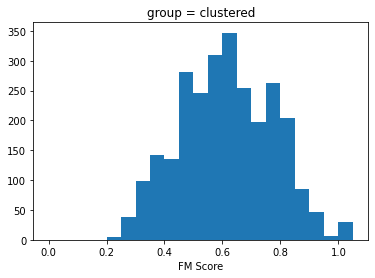

In [76]:
bins = [0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05]
n, bins, patches = plt.hist(clustered_scores, bins=bins)
plt.title('group = clustered')
plt.xlabel("FM Score")
plt.savefig("conv_results/clustered_fm.png")
plt.show()

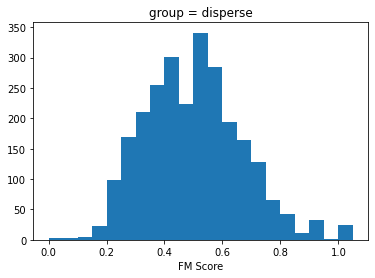

In [77]:
bins = [0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05]
n, bins, patches = plt.hist(disperse_scores, bins=bins)
plt.title('group = disperse')
plt.xlabel("FM Score")
plt.savefig("conv_results/disperse_fm.png")
plt.show()

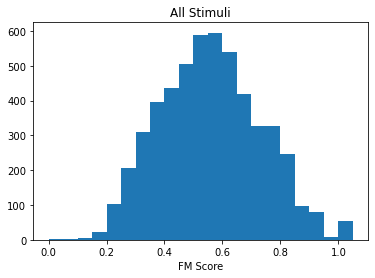

In [78]:
all_scores = []

# Gather all scores
scores_per_stim["all_scores"]
for stim_id in scores_per_stim["all_scores"]:
    all_scores += scores_per_stim["all_scores"][stim_id]
    
bins = [0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05]
n, bins, patches = plt.hist(all_scores, bins=bins)
plt.title('All Stimuli')
plt.xlabel("FM Score")
plt.savefig("conv_results/all_fm.png")
plt.show()